In [17]:
import zipfile
import os

# Define the folder path and the ZIP file path
folder_path = '/content/xgboost_price_prediction_model'
zip_file_path = 'xgboost_price_prediction_model.zip'

# Create a ZIP file
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file))


In [1]:
# Install PySpark version 3.1.2 silently
!pip install pyspark==3.1.2 -q
# Install findSpark silently
!pip install findspark -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 12.2 MB/s eta 0:00:00


In [2]:
!unzip /content/ml_features.zip
# !unzip /content/data_csv.zip

Archive:  /content/ml_features.zip
 extracting: content/ml_features.parquet/.part-00111-1dbedc7a-5ab5-4718-8ae2-df843cbcc2fa-c000.snappy.parquet.crc  
 extracting: content/ml_features.parquet/part-00054-1dbedc7a-5ab5-4718-8ae2-df843cbcc2fa-c000.snappy.parquet  
 extracting: content/ml_features.parquet/part-00076-1dbedc7a-5ab5-4718-8ae2-df843cbcc2fa-c000.snappy.parquet  
 extracting: content/ml_features.parquet/part-00070-1dbedc7a-5ab5-4718-8ae2-df843cbcc2fa-c000.snappy.parquet  
 extracting: content/ml_features.parquet/part-00169-1dbedc7a-5ab5-4718-8ae2-df843cbcc2fa-c000.snappy.parquet  
 extracting: content/ml_features.parquet/.part-00190-1dbedc7a-5ab5-4718-8ae2-df843cbcc2fa-c000.snappy.parquet.crc  
 extracting: content/ml_features.parquet/part-00039-1dbedc7a-5ab5-4718-8ae2-df843cbcc2fa-c000.snappy.parquet  
 extracting: content/ml_features.parquet/.part-00121-1dbedc7a-5ab5-4718-8ae2-df843cbcc2fa-c000.snappy.parquet.crc  
 extracting: content/ml_features.parquet/part-00181-1dbedc7a-5

In [3]:
# Suppressing warnings by defining a function 'warn' that does nothing
def warn(*args, **kwargs):
    pass

# Importing the 'warnings' module to handle warnings
import warnings

# Overriding the 'warn' function in the 'warnings' module with the defined function to suppress warnings
warnings.warn = warn

# Filtering out all warnings to be ignored
warnings.filterwarnings('ignore')

# FindSpark simplifies the process of using Apache Spark with Python
# Importing the 'findspark' module
import findspark

# Initializing FindSpark to locate Spark installation
findspark.init()

In [7]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler

from pyspark.sql import SparkSession
# Đọc lại file Parquet đã xử lý
output = "/content/content/ml_features.parquet"
spark = SparkSession.builder.appName("FeatureEngineering").getOrCreate()
df = spark.read.parquet(output)




In [9]:
# Xác định các cột đầu vào cho mô hình
feature_columns = ["week_of_year", "month", "year", "season",
                   "revenue_avg", "revenue_cumsum",
                   "sales_cumsum", "stock_cumsum", "price_volatility", "stockout_days", "year_offset"]

# VectorAssembler để gộp các đặc trưng thành một cột 'features'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Tạo mô hình Gradient Boosted Tree Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="price", maxIter=100)

# Tạo pipeline với các bước xử lý
pipeline = Pipeline(stages=[assembler, gbt])

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)


In [10]:
# Huấn luyện mô hình
model = pipeline.fit(train_data)


In [11]:
# Dự đoán trên tập kiểm tra
predictions = model.transform(test_data)

# Đánh giá mô hình với RMSE
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

RMSE: 27.705352957951295


In [12]:
import pandas as pd

# Chuyển đổi DataFrame của Spark thành Pandas DataFrame
predictions_pd = predictions.select("price", "prediction").toPandas()


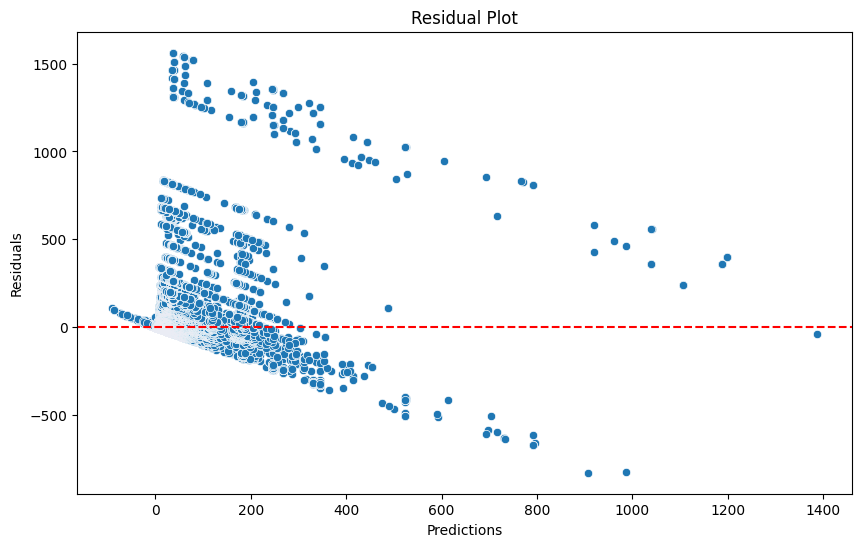

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính phần dư (residuals)
predictions_pd['residuals'] = predictions_pd['price'] - predictions_pd['prediction']

# Vẽ Residual Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=predictions_pd['prediction'], y=predictions_pd['residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


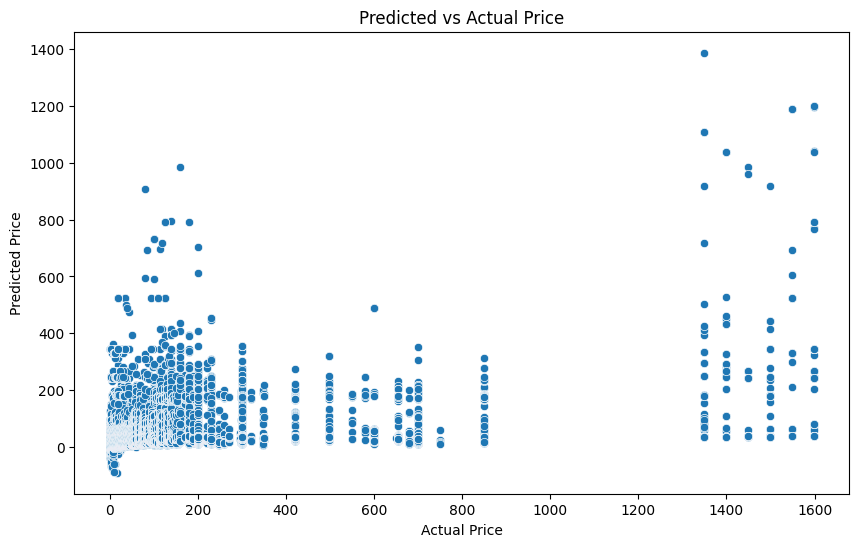

In [14]:
# Vẽ biểu đồ dự đoán vs. giá trị thực
plt.figure(figsize=(10,6))
sns.scatterplot(x=predictions_pd['price'], y=predictions_pd['prediction'])
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()


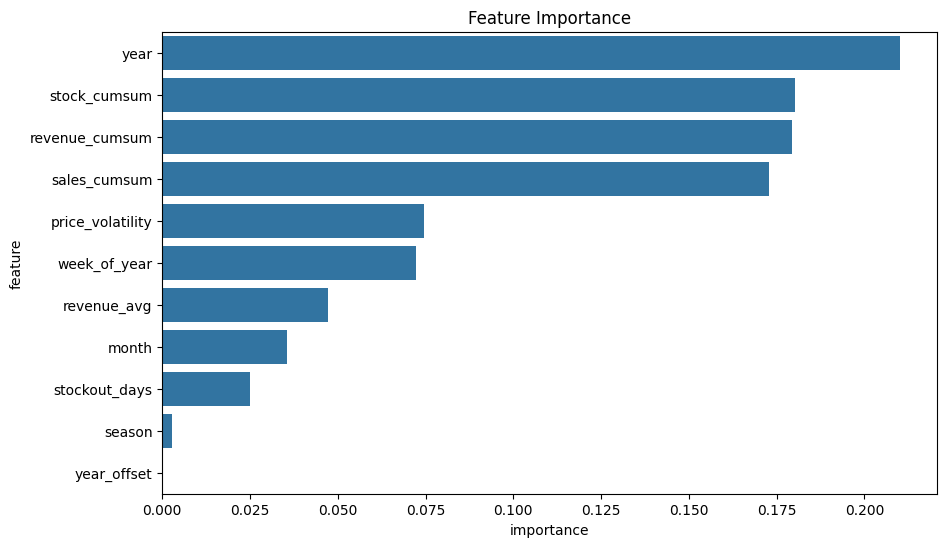

In [15]:
# Lấy tầm quan trọng của các đặc trưng
importances = model.stages[-1].featureImportances.toArray()

# Tạo DataFrame từ các feature và importances
features_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
})

# Vẽ biểu đồ tầm quan trọng của đặc trưng
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=features_df.sort_values(by='importance', ascending=False))
plt.title('Feature Importance')
plt.show()


In [16]:
# Lưu mô hình đã huấn luyện
model.save("/content/xgboost_price_prediction_model")
